In [83]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import functools
from scipy.stats import poisson

In [103]:
# Generate training data for sales probability regression
def generate_train_data(B=1000, T=100):

    def rank(a, p):
        return np.argsort(np.hstack((a, p)))[:,0]
    
    our_price = np.random.uniform(0, 20, (B, 1))
    competitor_prices = np.random.uniform(0, 20, (B, 5))
    our_rank = np.reshape(rank(our_price, competitor_prices), (B, 1))
    X = np.hstack((our_price, competitor_prices, our_rank))
    Y = (our_rank == 0).astype(int).ravel()
    
    return (X, Y)

X, Y = generate_train_data()

NameError: name 'our_rank' is not defined

In [85]:
# Train sales probability model
def make_model(X, Y):
    regr = LogisticRegression()
    regr.fit(X, Y)
    def predict(x):
        return regr.predict_proba(x)[:, 1]
    return predict

sales_model = make_model(X, Y)

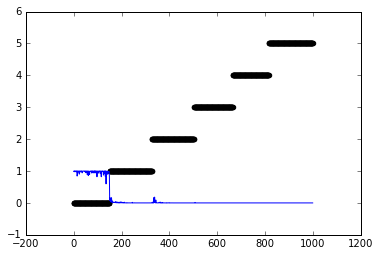

In [86]:
# Plot sales probability model
X_sort = np.sort(X.view('f8,f8,f8,f8,f8,f8,f8'), order=['f6'], axis=0).view(float)
plt.scatter(np.arange(0, B), X_sort[:, 6], color='black')
plt.plot(np.arange(0, B), salesModel(X_sort), color='blue', linewidth=1)

plt.show()

In [120]:
# Run Bellmann equation to calculate best price
def optimize_price(t, sales_model, competitor_prices,
               T=5, N=15, 
               price_range=np.arange(0.1, 20, 0.1), 
               i_range=np.arange(0, 2), 
               L=0.01, delta=0.99, Z=0.5):

    
    def rank(a, p):
        return np.argsort(np.hstack((a, p)))[0]

    def sales_prob(i, price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return poisson.pmf(i, sales_model(x))


    @functools.lru_cache(maxsize=None)
    def _V(price, t, n):
        def mapper(i):
            if i > n:
                return 0
            pi = sales_prob(i, price)
            today_profit = min(n, i) * price
            holding_costs = n * L
            V_future, _ = V(t + 1, max(0, n - i))
            exp_future_profits = delta * V_future
            return pi * (today_profit - holding_costs + exp_future_profits)
        return sum([mapper(i) for i in i_range])

    def V(t, n):
        if t >= T:
            return (n * Z, 0)
        if n <= 0:
            return (0, 0)

        V_values = np.zeros(price_range.shape)
        for i, price in enumerate(price_range):
            v = _V(price, t, n)
            V_values[i] = v 

        V_opt = np.max(V_values)
        price_opt = price_range[np.argmax(V_values)]
        return (price_opt, V_opt)
    
    return V(t, N)

optimize_price(0, sales_model, np.random.uniform(0, 20, 5))

(1.7000000000000002, 1.5842922780105928)

In [ ]:
def simulation(sales_model, T=20, N=15):
    competitor_prices = np.random.uniform(0, 20, 5)
    n = N
    
    def rank(a, p):
        return np.argsort(np.hstack((a, p)))[0]
    
    def sales_prob(price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return sales_model(x)
        
    for t in range(0, T):
        price, _ = optimize_price(t, sales_model, competitor_prices, N=n, T=T)
        pi = sales_prob(price)
        n = max(0, n - np.random.poisson(pi))
        print(t, n, price, competitor_prices, rank(price, competitor_prices))
        competitor_prices = competitor_prices * np.random.uniform(0.8, 1.2, 5)
        
            
simulation(sales_model)

0 15 3.0 [  3.70063719   3.05945302   8.73289429  12.51829413  13.99064079] 0
